In [18]:
import numpy as np
import sounddevice as sd
import datetime
from scipy.signal import butter, lfilter
from scipy.io import wavfile

def generate_white_noise(duration, sample_rate=44100):
    """
    generate white noise
    to make experiments reproducible, set a seed
    """
    np.random.seed(42)
    white_noise = np.random.randn(int(sample_rate * duration))
    return white_noise

def band_limited_white_noise(low, high, duration, sample_rate=44100):
    """Apply a butterworth filter"""
    white_noise = generate_white_noise(duration, sample_rate)
    nyq = 0.5 * sample_rate
    low = low / nyq
    high = high / nyq
    b, a = butter(5, [low, high], btype='band')
    band_limited = lfilter(b, a, white_noise)
    return band_limited

def pseudo_white_noise(low, high, repetitions, duration, sample_rate=44100):
    """Generate pseudoNoise"""
    # use sinusoidal signal with random phase as pseudo noise
    # t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    # pseudo_noise = np.sin(2 * np.pi * 20 * t + np.random.uniform(0, 2 * np.pi))
    band_limited_noise = band_limited_white_noise(low, high, duration/repetitions)
    pseudo_noise = np.tile(band_limited_noise, repetitions)
    # store the sound signal
    # Format the date and time
    filename = f"pseudoNoise_{low}_{high}.wav"
    wavfile.write(filename, sample_rate, pseudo_noise)
    return pseudo_noise

import numpy as np
import sounddevice as sd

def play_sound(sound, channel, sample_rate=44100):
    """Play the sound on a specified channel (0 or 1)"""
    if sound.ndim == 1:
        # If the sound is mono, duplicate it for both channels
        sound = np.tile(sound[:, np.newaxis], (1, 2))
    
    # Create a stereo sound array with one channel set to zero
    stereo_sound = np.zeros_like(sound)
    
    if channel == 0:
        # Play on left channel
        stereo_sound[:, 0] = sound[:, 0]
    elif channel == 1:
        # Play on right channel
        stereo_sound[:, 1] = sound[:, 1]
    else:
        raise ValueError("Channel must be 0 or 1")
    
    sd.play(stereo_sound, samplerate=sample_rate)
    sd.wait()


In [11]:

# generate and play white noise
# for i in np.arange(10):
duration = 20 # 10s
band_limited_noise = band_limited_white_noise(20, 12000, duration)


In [20]:

play_sound(sound = band_limited_noise, channel=1)

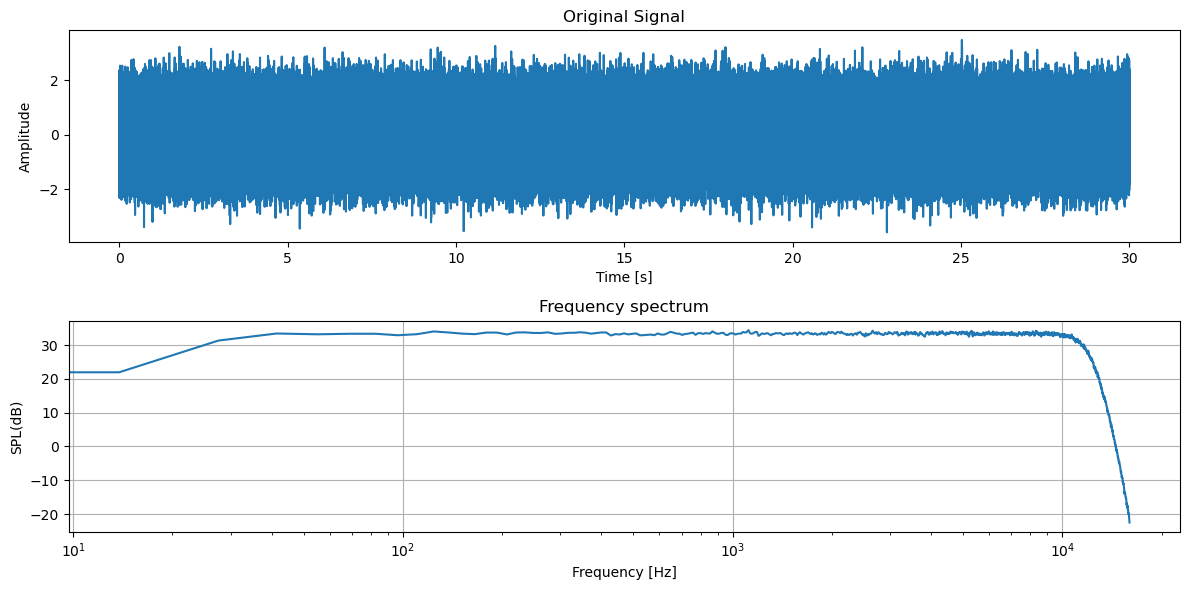

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# parameters：
sample_rate=44100
time_signal = np.arange(0, duration, 1/sample_rate)
data_signal = band_limited_noise

# FFT
frequencies, fft_result = welch(data_signal, fs=sample_rate, scaling='spectrum', nperseg=3200, return_onesided=True)

# choose the frequency range of fft analysis
min_freq = 0
max_freq = 16000
mask = (frequencies >= min_freq) & (frequencies <= max_freq)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_signal, data_signal)
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.semilogx(frequencies[mask],20*np.log10(np.abs(fft_result[mask])/20e-6))
plt.title('Frequency spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('SPL(dB)')
plt.tight_layout()
plt.grid()
plt.show()


In [25]:
# Generate pseudo white noise
repetitions = 5
duration = 10
pseudo_noise = pseudo_white_noise(2000, 4000, repetitions, duration)

In [27]:
# Play pseudo White Noise
sample_rate, pseudo_noise = wavfile.read("pseudoNoise_2000_4000.wav")

repetitions = 1
pseudo_noise = np.tile(pseudo_noise, repetitions)
play_sound(pseudo_noise)
